<h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px; color:#000;" align="center">SCHOOL DROPOUT IN SOGAMOSO</h1>
<p style="width: 100%; text-align: center; margin: 0px; padding: 0px; font-size: 24px; color:#000;" align="center">| MODEL EXPLANATION Notebook |</p>
<p style="width: 100%; text-align: center; margin: 0px; padding: 0px; font-size: 20px; color:#000;" align="center">Correlation One - DS4A</p>
<p style="text-align:center;">This notebook contains the <b>SELECTED MODEL</b> to make the classification predictions.</p>

## 1. Libraries

In [1]:
# General
import pandas as pd
import numpy as np
from numpy import sqrt

# Scikit-learn ligrary
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (StandardScaler, OneHotEncoder,
                                   OrdinalEncoder, FunctionTransformer)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (roc_auc_score, confusion_matrix, recall_score,
                             f1_score, precision_score, ConfusionMatrixDisplay,
                             roc_curve, precision_recall_curve)
from sklearn.inspection import permutation_importance


# Imbalanced-learn ligrary
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

# Own specific functions 
from functions import *

## 2. Importing files

In [2]:
df_students = pd.read_csv("datasets/df_students.csv")

In [3]:
df_analysis(df_students, key_columns=["PER_ID_AÑO"], analysis_type="header")


Analysis header
--------------------------------------------------------------------------------
- Dataset shape:			 311866 rows and 35 columns
- Total of NaN values:			 183550
- Percentage of NaN:			 1.68 %
- Total of infinite values:		 0
- Total of empty columns:		 0
- Total of empty rows:			 0
- Total of full duplicates rows:	 0
- Unique indexes:			 True
- Memory usage:				 83.3+ MB

- The key(s):	 ['PER_ID_AÑO'] is not present multiple times in the dataframe. 
		 It CAN be used as a primary key.


## 3. Splitting data

First of all, we are going to separate the data to predict (2022) from the data to do the training (from 2013 to 2021)

In [4]:
df_students_2022 = df_students[df_students["AÑO"]==2022].copy()
df_students_2022["ESTADO"] = np.NaN

df_students_2022.to_csv("datasets\df_students_2022.csv", index=False)

In [5]:
df_students = df_students[df_students["AÑO"]!=2022].copy()

Now, we are let's identify the training columns in the dataset

In [6]:
NOT_TRAINING_COLUMNS = [
    "ESTADO", "AÑO", "PER_ID_AÑO", "PER_ID", "INSTITUCION_LATITUDE", "INSTITUCION_LONGITUD",
]

TRAINING_COLUMNS = [col for col in df_students if col not in NOT_TRAINING_COLUMNS]

Let's proced to split the data

In [7]:
X = df_students[TRAINING_COLUMNS].copy()

In [8]:
y_target = df_students.loc[:, "ESTADO"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.2,
                                                    stratify=y_target, random_state=42)

In [10]:
print("X_train: {}".format(X_train.shape))
print("y_train: {}".format(y_train.shape))
print(30*"-")
print("X_test: {}".format(X_test.shape))
print("y_test: {}".format(y_test.shape))

X_train: (224949, 29)
y_train: (224949,)
------------------------------
X_test: (56238, 29)
y_test: (56238,)


## 4. Data preprocessing

In [11]:
def boolean_transformation(X):
    return X.astype(int)

In [12]:
X_train.columns

Index(['INSTITUCION', 'EDAD', 'GENERO', 'GRADO_COD', 'JORNADA', 'ESTRATO',
       'PAIS_ORIGEN', 'DISCAPACIDAD', 'SRPA', 'INSTITUCION_SECTOR',
       'INSTITUCION_MODELO', 'INSTITUCION_APOYO_ACADEMICO_ESPECIAL',
       'INSTITUCION_ZONA', 'INSTITUCION_CARACTER',
       'INSTITUCION_NUMERO_DE_SEDES', 'INSTITUCION_ESTADO',
       'INSTITUCION_PRESTADOR_DE_SERVICIO', 'INSTITUCION_TAMAÑO',
       'INSTITUCION_NIVEL_BASICA_PRIMARIA',
       'INSTITUCION_NIVEL_SECUNDARIA_PRIMARIA', 'INSTITUCION_NIVEL_MEDIA',
       'INSTITUCION_NIVEL_PREESCOLAR', 'INSTITUCION_NIVEL_PRIMERA_INFANCIA',
       'INSTITUCION_ESPECIALIDAD_ACADÉMICA',
       'INSTITUCION_ESPECIALIDAD_AGROPECUARIO',
       'INSTITUCION_ESPECIALIDAD_COMERCIAL',
       'INSTITUCION_ESPECIALIDAD_INDUSTRIAL',
       'INSTITUCION_ESPECIALIDAD_NO_APLICA', 'INSTITUCION_ESPECIALIDAD_OTRO'],
      dtype='object')

In [13]:
CATEGORICAL_FEATURES = [
    "INSTITUCION", "GENERO", "JORNADA", "PAIS_ORIGEN", "DISCAPACIDAD", "SRPA", "INSTITUCION_SECTOR",
    "INSTITUCION_MODELO", "INSTITUCION_APOYO_ACADEMICO_ESPECIAL", "INSTITUCION_ZONA", "INSTITUCION_CARACTER",
    "INSTITUCION_ESTADO", "INSTITUCION_PRESTADOR_DE_SERVICIO"
]
ORDINAL_FEATURES = [
    "ESTRATO", "INSTITUCION_TAMAÑO"
]
ORDINAL_FEATURES = [
    "GRADO_COD", "ESTRATO", "INSTITUCION_TAMAÑO"
]
NUMERICAL_FEATURES = [
    "EDAD", "INSTITUCION_NUMERO_DE_SEDES"
]
BOOLEAN_FEATURES = [
    "INSTITUCION_NIVEL_BASICA_PRIMARIA", "INSTITUCION_NIVEL_SECUNDARIA_PRIMARIA", "INSTITUCION_NIVEL_MEDIA",
    "INSTITUCION_NIVEL_PREESCOLAR", "INSTITUCION_NIVEL_PRIMERA_INFANCIA", "INSTITUCION_ESPECIALIDAD_ACADÉMICA", 
    "INSTITUCION_ESPECIALIDAD_AGROPECUARIO", "INSTITUCION_ESPECIALIDAD_COMERCIAL", 
    "INSTITUCION_ESPECIALIDAD_INDUSTRIAL", "INSTITUCION_ESPECIALIDAD_NO_APLICA",
    "INSTITUCION_ESPECIALIDAD_OTRO"
]

In [14]:
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))

ordinal_pipeline = make_pipeline(OrdinalEncoder(categories=[
    [-2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0],
    ['ESTRATO 0', 'ESTRATO 1', 'ESTRATO 2', 'ESTRATO 3', 'ESTRATO 4', 'ESTRATO 5', 'ESTRATO 6'],
    ['Pequeña', 'Mediana',  'Grande']
]))

numerical_pipeline = make_pipeline(StandardScaler())

boolean_pipeline = make_pipeline(FunctionTransformer(boolean_transformation))

In [15]:
preprocessor = make_column_transformer(
    (categorical_pipeline, CATEGORICAL_FEATURES),
    (ordinal_pipeline, ORDINAL_FEATURES),
    (numerical_pipeline, NUMERICAL_FEATURES),
    (boolean_pipeline, BOOLEAN_FEATURES)
)

## 5. Custom evaluations

### 5.1. Custom Score

We are going to penalize False Negative that are students dropped out, and they were predicted incorrectly.<br> Due to that, we are going to define a Custom Score.

In [16]:
def custom_score(y_test, y_pred):
    """
    Method used to calculate a score based on the penalization of False Negatives.

    Parameters:
    -----------------
        y_test (series): True values
        y_pred (series): Predicted values
        threshold (float): Threshold value to use
        
    Returns:
    -----------------
        Score. (float): Score obtained based on the rules defined to measure. 
    """
    
    TN_rate = 1        # Students that do not drop out and were predicted correctly
    TP_rate = 1        # Students that dropped out and were predicted correctly
    FP_rate = -1       # Students that do not drop out and were predicted incorrectly
    FN_rate = -10      # Students that dropped out and were predicted incorrectly
    
    # Getting all values based on confusion matrix
    (TN, FP, FN, TP) = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()

    # Total of default and not default cases
    total_not_default = TN + FP     # Not drop out cases
    total_default = TP + FN         # Drop out cases 
    
    gain_total = TN*TN_rate + TP*TP_rate + FP*FP_rate + FN*FN_rate
    gain_maximun = total_not_default*TN_rate + total_default*TP_rate
    gain_minumun = total_not_default*TN_rate + total_default*FN_rate
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain_total - gain_minumun) / (gain_maximun - gain_minumun)    
    return score


### 5.2. Threshold selection

Based on the probability predictions and Custom Score, we are going to identify the best treshold to mesure our models.

In [17]:
def threshold_selection(y_test, y_prob):
    """
    Method used to calculate the threshold based on the Custom Score.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        y_test (1d array-like): True values
        y_prob (1d array-like): Probabilite values predicted
        
    Returns:
    -----------------
        threshold (float) : Best threshold value
        Threshold (image) : Plot the threshold and the best score
    """
    
    thresholds = np.arange(0, 1, 0.001)
    scores = []
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype("int")
        score = custom_score(y_test, y_pred)
        scores.append(score)
        
    scores = np.asarray(scores)
    ix = np.argmax(scores)
    
    best_threshold, best_score = (thresholds[ix], round(scores[ix], 3))
    
    print("Best results")
    print("- Best Threshold:\t", best_threshold)
    print("- Best Score:\t\t", best_score)
    print("\n")
    
    plt.subplots(1, figsize=(6, 5))
    plt.plot(thresholds, scores, lw=1)
    plt.axvline(best_threshold, ls="--", lw=1, c="r")
    plt.title("Threshold")
    plt.xlabel("proba threshold")
    plt.ylabel("Score performed")
    plt.show()
    
    return best_threshold

## 6. Modelisation

<div class="admonition warning alert alert-info">
<p>To model the classification predictions, we are going to work with <b>Oversampling - Gradiend Boosting</b></p>
</div>

To treat the unbalanced class, we are going to implement OverSampling technique with SMOTE.

In [18]:
smote = SMOTE(random_state=42, n_jobs=-1)

In [19]:
gbc_parameters = {
    "learning_rate": 0.01,
    "max_depth": 3,
    "n_estimators": 5
}

In [20]:
imbpipeline_clf = imbpipeline(steps=[
    ["preprocessor", preprocessor],
    ["smote", smote],
    ["GradientBoosting", GradientBoostingClassifier(**gbc_parameters,
                                                validation_fraction=0.2, 
                                                n_iter_no_change=5,
                                                random_state=42)
    ]
])

Executing the model with the complete dataset

In [21]:
imbpipeline_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['INSTITUCION', 'GENERO',
                                                   'JORNADA', 'PAIS_ORIGEN',
                                                   'DISCAPACIDAD', 'SRPA',
                                                   'INSTITUCION_SECTOR',
                                                   'INSTITUCION_MODELO',
                                                   'INSTITUCION_APOYO_ACADEMICO_ESPECIAL',
                                                   'INSTITUCION_ZONA',
                                                   'INSTITUCION_CARACTER',
                                                   'INS...
                                                   'INSTITUCION_ESPECIALIDAD_AGROPECUARIO',
                                                   'INSTITUCION_ESPECIALIDAD_COMERCIAL',
                                                   'INSTITUCION_ESPECIALIDAD_INDUSTRIAL',
                                                   'INSTITUCION_ESPECIALIDAD_NO_APLICA',
                                                   'INSTITUCION_ESPECIALIDAD_OTRO'])])),
                ('smote', SMOTE(n_jobs=-1, random_state=42)),
                ['GradientBoosting',
                 GradientBoostingClassifier(learning_rate=0.01, n_estimators=5,
                                            n_iter_no_change=5, random_state=42,
                                            validation_fraction=0.2)]])

Predict the probabilities

In [22]:
y_prob = imbpipeline_clf.predict_proba(X_test)
y_prob = y_prob[:, 1]

Let's selet the threshold based on the best parameters

Best results
- Best Threshold:	 0.503
- Best Score:		 0.199




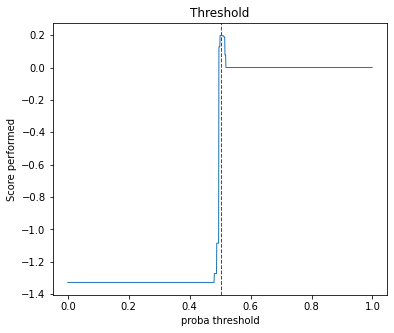

In [23]:
threshold = threshold_selection(y_test, y_prob)

Making the predictions based on the probabilities and threshold

In [24]:
y_pred = (y_prob >= threshold).astype(int)

Now, we can get the metrics

In [25]:
roc_auc = round(roc_auc_score(y_test, y_prob), 3)
recall_0, recall_1 = recall_score(y_test, y_pred, average=None).round(3)
f1 = round(f1_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred), 3)

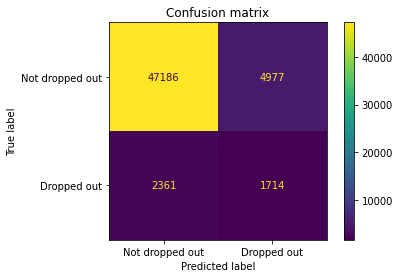

In [26]:
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                                  display_labels=["Not dropped out", 
                                                                  "Dropped out"])
_ = display.ax_.set_title("Confusion matrix")

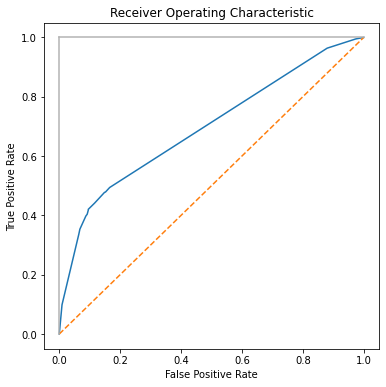

In [27]:
fpr = dict()
tpr = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())

plt.subplots(1, figsize=(6, 6))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

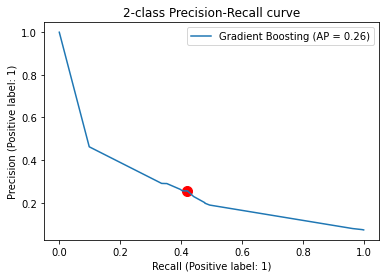

In [28]:
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

plt.subplots(1, figsize=(6, 4))
plt.plot(recall_, precision_,  color="#1F77B4");
plt.scatter(recall_1, precision, marker="o", s=100, color="red", label="Best")
plt.xlabel("Recall (Positive label: 1)")
plt.ylabel("Precision (Positive label: 1)")
plt.title("2-class Precision-Recall curve")
plt.legend(["Gradient Boosting (AP = %.2f)"% (precision)], loc=0)
plt.show()

In [30]:
df_models_metrics_complete = pd.DataFrame({
    "Model" : ["OverSampling - Gradient Boosting - EDAD"],
    "Threshold" : threshold,
    "ROC-AUC" : roc_auc,    
    "Recall - 0" : recall_0,
    "Recall - 1" : recall_1,
    "Precision" : precision,
    "F1" : f1,    
})

df_models_metrics_complete

,Model,Threshold,ROC-AUC,Recall - 0,Recall - 1,Precision,F1
0,OverSampling - Gradient Boosting - EDAD,0.503,0.695,0.905,0.421,0.256,0.318


## 7. Gloabal interpretation

In [31]:
results = permutation_importance(imbpipeline_clf, X_train, y_train)

In [32]:
df_importance = pd.DataFrame({
                    "Feature" : X_train.columns,
                    "Importance" : results.importances_mean
                })

df_importance = df_importance.sort_values("Importance", ascending=False)

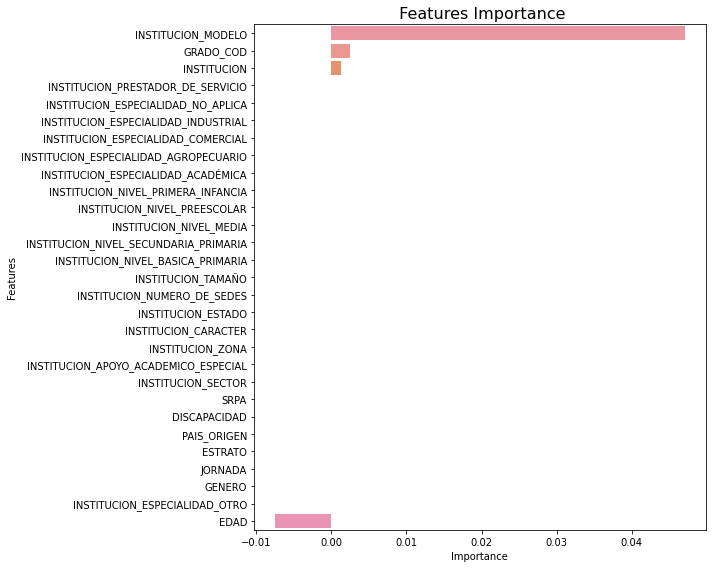

In [33]:
# Initializing figure    
fig = plt.subplots(figsize=(10, 8))

plot = sns.barplot(data=df_importance, y=df_importance["Feature"], x=df_importance["Importance"])

plt.title(" Features Importance", fontdict={ "fontsize": 16, "fontweight": "normal" })
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [34]:
def age_clasification(age):
    if 0 <= age <= 5:
        new_age = "0-5"
    if 6 <= age <= 10:
        new_age = "6-10"
    if 11 <= age <= 15:
        new_age = "11-15"
    if 16 <= age <= 20:
        new_age = "16-20"
    if 21 <= age <= 25:
        new_age = "21-25"
    if 26 <= age:
        new_age = "26+"
    return new_age

In [35]:
df_students["EDAD_CLASIFICACION"] = df_students["EDAD"].apply(age_clasification)

In [36]:
df_students[["EDAD", "EDAD_CLASIFICACION"]]

,EDAD,EDAD_CLASIFICACION
0,24,21-25
1,23,21-25
2,20,16-20
3,24,21-25
4,27,26+
...,...,...
281182,7,6-10
281183,9,6-10
281184,7,6-10
281185,9,6-10


Now, we are let's identify the training columns in the dataset

In [37]:
NOT_TRAINING_COLUMNS = [
    "ESTADO", "AÑO", "PER_ID_AÑO", "PER_ID", "EDAD", "INSTITUCION_LATITUDE", "INSTITUCION_LONGITUD"
]

TRAINING_COLUMNS = [col for col in df_students if col not in NOT_TRAINING_COLUMNS]

Let's proced to split the data

In [38]:
X = df_students[TRAINING_COLUMNS].copy()

In [39]:
y_target = df_students.loc[:, "ESTADO"]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.2,
                                                    stratify=y_target, random_state=42)

In [41]:
print("X_train: {}".format(X_train.shape))
print("y_train: {}".format(y_train.shape))
print(30*"-")
print("X_test: {}".format(X_test.shape))
print("y_test: {}".format(y_test.shape))

X_train: (224949, 29)
y_train: (224949,)
------------------------------
X_test: (56238, 29)
y_test: (56238,)


## 4. Data preprocessing

In [42]:
def boolean_transformation(X):
    return X.astype(int)

In [43]:
X_train.columns

Index(['INSTITUCION', 'GENERO', 'GRADO_COD', 'JORNADA', 'ESTRATO',
       'PAIS_ORIGEN', 'DISCAPACIDAD', 'SRPA', 'INSTITUCION_SECTOR',
       'INSTITUCION_MODELO', 'INSTITUCION_APOYO_ACADEMICO_ESPECIAL',
       'INSTITUCION_ZONA', 'INSTITUCION_CARACTER',
       'INSTITUCION_NUMERO_DE_SEDES', 'INSTITUCION_ESTADO',
       'INSTITUCION_PRESTADOR_DE_SERVICIO', 'INSTITUCION_TAMAÑO',
       'INSTITUCION_NIVEL_BASICA_PRIMARIA',
       'INSTITUCION_NIVEL_SECUNDARIA_PRIMARIA', 'INSTITUCION_NIVEL_MEDIA',
       'INSTITUCION_NIVEL_PREESCOLAR', 'INSTITUCION_NIVEL_PRIMERA_INFANCIA',
       'INSTITUCION_ESPECIALIDAD_ACADÉMICA',
       'INSTITUCION_ESPECIALIDAD_AGROPECUARIO',
       'INSTITUCION_ESPECIALIDAD_COMERCIAL',
       'INSTITUCION_ESPECIALIDAD_INDUSTRIAL',
       'INSTITUCION_ESPECIALIDAD_NO_APLICA', 'INSTITUCION_ESPECIALIDAD_OTRO',
       'EDAD_CLASIFICACION'],
      dtype='object')

In [44]:
CATEGORICAL_FEATURES = [
    "INSTITUCION", "GENERO", "JORNADA", "PAIS_ORIGEN", "DISCAPACIDAD", "SRPA", "INSTITUCION_SECTOR",
    "INSTITUCION_MODELO", "INSTITUCION_APOYO_ACADEMICO_ESPECIAL", "INSTITUCION_ZONA", "INSTITUCION_CARACTER",
    "INSTITUCION_ESTADO", "INSTITUCION_PRESTADOR_DE_SERVICIO"
]
ORDINAL_FEATURES = [
    "ESTRATO", "INSTITUCION_TAMAÑO"
]
ORDINAL_FEATURES = [
    "EDAD_CLASIFICACION", "GRADO_COD", "ESTRATO", "INSTITUCION_TAMAÑO"
]
NUMERICAL_FEATURES = [
    "INSTITUCION_NUMERO_DE_SEDES"
]
BOOLEAN_FEATURES = [
    "INSTITUCION_NIVEL_BASICA_PRIMARIA", "INSTITUCION_NIVEL_SECUNDARIA_PRIMARIA", "INSTITUCION_NIVEL_MEDIA",
    "INSTITUCION_NIVEL_PREESCOLAR", "INSTITUCION_NIVEL_PRIMERA_INFANCIA", "INSTITUCION_ESPECIALIDAD_ACADÉMICA", 
    "INSTITUCION_ESPECIALIDAD_AGROPECUARIO", "INSTITUCION_ESPECIALIDAD_COMERCIAL", 
    "INSTITUCION_ESPECIALIDAD_INDUSTRIAL", "INSTITUCION_ESPECIALIDAD_NO_APLICA",
    "INSTITUCION_ESPECIALIDAD_OTRO"
]

In [45]:
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))

ordinal_pipeline = make_pipeline(OrdinalEncoder(categories=[
    ["0-5", "6-10", "11-15", "16-20", "21-25","26+"],
    [-2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0],
    ['ESTRATO 0', 'ESTRATO 1', 'ESTRATO 2', 'ESTRATO 3', 'ESTRATO 4', 'ESTRATO 5', 'ESTRATO 6'],
    ['Pequeña', 'Mediana',  'Grande']
]))

numerical_pipeline = make_pipeline(StandardScaler())

boolean_pipeline = make_pipeline(FunctionTransformer(boolean_transformation))

In [46]:
preprocessor = make_column_transformer(
    (categorical_pipeline, CATEGORICAL_FEATURES),
    (ordinal_pipeline, ORDINAL_FEATURES),
    (numerical_pipeline, NUMERICAL_FEATURES),
    (boolean_pipeline, BOOLEAN_FEATURES)
)

## 5. Custom evaluations

### 5.1. Custom Score

We are going to penalize False Negative that are students dropped out, and they were predicted incorrectly.<br> Due to that, we are going to define a Custom Score.

In [47]:
def custom_score(y_test, y_pred):
    """
    Method used to calculate a score based on the penalization of False Negatives.

    Parameters:
    -----------------
        y_test (series): True values
        y_pred (series): Predicted values
        threshold (float): Threshold value to use
        
    Returns:
    -----------------
        Score. (float): Score obtained based on the rules defined to measure. 
    """
    
    TN_rate = 1        # Students that do not drop out and were predicted correctly
    TP_rate = 1        # Students that dropped out and were predicted correctly
    FP_rate = -1       # Students that do not drop out and were predicted incorrectly
    FN_rate = -10      # Students that dropped out and were predicted incorrectly
    
    # Getting all values based on confusion matrix
    (TN, FP, FN, TP) = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()

    # Total of default and not default cases
    total_not_default = TN + FP     # Not drop out cases
    total_default = TP + FN         # Drop out cases 
    
    gain_total = TN*TN_rate + TP*TP_rate + FP*FP_rate + FN*FN_rate
    gain_maximun = total_not_default*TN_rate + total_default*TP_rate
    gain_minumun = total_not_default*TN_rate + total_default*FN_rate
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain_total - gain_minumun) / (gain_maximun - gain_minumun)    
    return score


### 5.2. Threshold selection

Based on the probability predictions and Custom Score, we are going to identify the best treshold to mesure our models.

In [48]:
def threshold_selection(y_test, y_prob):
    """
    Method used to calculate the threshold based on the Custom Score.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        y_test (1d array-like): True values
        y_prob (1d array-like): Probabilite values predicted
        
    Returns:
    -----------------
        threshold (float) : Best threshold value
        Threshold (image) : Plot the threshold and the best score
    """
    
    thresholds = np.arange(0, 1, 0.001)
    scores = []
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype("int")
        score = custom_score(y_test, y_pred)
        scores.append(score)
        
    scores = np.asarray(scores)
    ix = np.argmax(scores)
    
    best_threshold, best_score = (thresholds[ix], round(scores[ix], 3))
    
    print("Best results")
    print("- Best Threshold:\t", best_threshold)
    print("- Best Score:\t\t", best_score)
    print("\n")
    
    plt.subplots(1, figsize=(6, 5))
    plt.plot(thresholds, scores, lw=1)
    plt.axvline(best_threshold, ls="--", lw=1, c="r")
    plt.title("Threshold")
    plt.xlabel("proba threshold")
    plt.ylabel("Score performed")
    plt.show()
    
    return best_threshold

## 6. Modelisation

<div class="admonition warning alert alert-info">
<p>To model the classification predictions, we are going to work with <b>Oversampling - Gradiend Boosting</b></p>
</div>

To treat the unbalanced class, we are going to implement OverSampling technique with SMOTE.

In [49]:
smote = SMOTE(random_state=42, n_jobs=-1)

In [50]:
gbc_parameters = {
    "learning_rate": 0.01,
    "max_depth": 3,
    "n_estimators": 5
}

In [51]:
imbpipeline_clf = imbpipeline(steps=[
    ["preprocessor", preprocessor],
    ["smote", smote],
    ["GradientBoosting", GradientBoostingClassifier(**gbc_parameters,
                                                validation_fraction=0.2, 
                                                n_iter_no_change=5,
                                                random_state=42)
    ]
])

Executing the model with the complete dataset

In [52]:
imbpipeline_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['INSTITUCION', 'GENERO',
                                                   'JORNADA', 'PAIS_ORIGEN',
                                                   'DISCAPACIDAD', 'SRPA',
                                                   'INSTITUCION_SECTOR',
                                                   'INSTITUCION_MODELO',
                                                   'INSTITUCION_APOYO_ACADEMICO_ESPECIAL',
                                                   'INSTITUCION_ZONA',
                                                   'INSTITUCION_CARACTER',
                                                   'INS...
                                                   'INSTITUCION_ESPECIALIDAD_AGROPECUARIO',
                                                   'INSTITUCION_ESPECIALIDAD_COMERCIAL',
                                                   'INSTITUCION_ESPECIALIDAD_INDUSTRIAL',
                                                   'INSTITUCION_ESPECIALIDAD_NO_APLICA',
                                                   'INSTITUCION_ESPECIALIDAD_OTRO'])])),
                ('smote', SMOTE(n_jobs=-1, random_state=42)),
                ['GradientBoosting',
                 GradientBoostingClassifier(learning_rate=0.01, n_estimators=5,
                                            n_iter_no_change=5, random_state=42,
                                            validation_fraction=0.2)]])

Predict the probabilities

In [53]:
y_prob = imbpipeline_clf.predict_proba(X_test)
y_prob = y_prob[:, 1]

Let's selet the threshold based on the best parameters

Best results
- Best Threshold:	 0.508
- Best Score:		 0.192




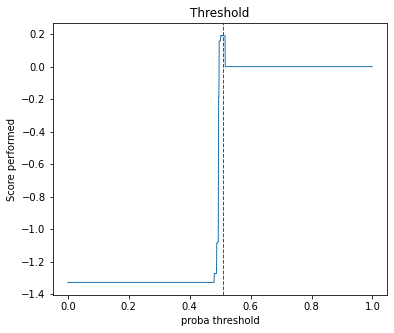

In [54]:
threshold = threshold_selection(y_test, y_prob)

Making the predictions based on the probabilities and threshold

In [55]:
y_pred = (y_prob >= threshold).astype(int)

Now, we can get the metrics

In [56]:
roc_auc = round(roc_auc_score(y_test, y_prob), 3)
recall_0, recall_1 = recall_score(y_test, y_pred, average=None).round(3)
f1 = round(f1_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred), 3)

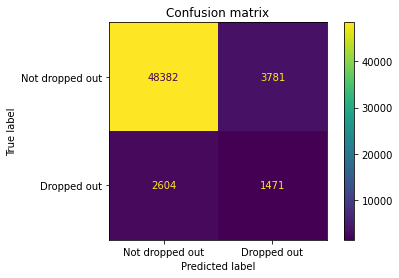

In [57]:
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                                  display_labels=["Not dropped out", 
                                                                  "Dropped out"])
_ = display.ax_.set_title("Confusion matrix")

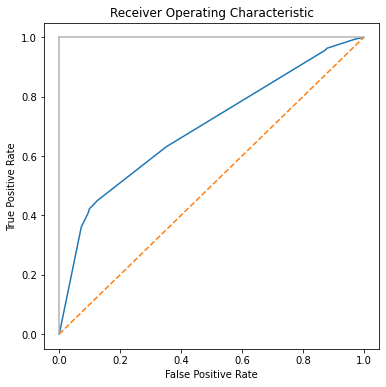

In [58]:
fpr = dict()
tpr = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())

plt.subplots(1, figsize=(6, 6))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

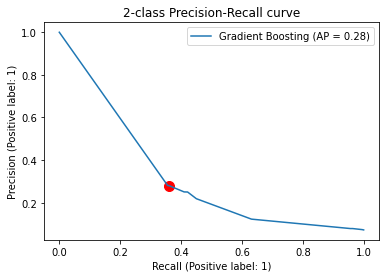

In [59]:
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

plt.subplots(1, figsize=(6, 4))
plt.plot(recall_, precision_,  color="#1F77B4");
plt.scatter(recall_1, precision, marker="o", s=100, color="red", label="Best")
plt.xlabel("Recall (Positive label: 1)")
plt.ylabel("Precision (Positive label: 1)")
plt.title("2-class Precision-Recall curve")
plt.legend(["Gradient Boosting (AP = %.2f)"% (precision)], loc=0)
plt.show()

In [61]:
df_temp  = pd.DataFrame({
    "Model" : ["OVerSampling - Gradient Boosting - EDAD clasificacion"],
    "Threshold" : threshold,
    "ROC-AUC" : roc_auc,    
    "Recall - 0" : recall_0,
    "Recall - 1" : recall_1,
    "Precision" : precision,
    "F1" : f1,    
})

df_models_metrics_complete = pd.concat([df_models_metrics_complete, df_temp])
df_models_metrics_complete.reset_index(drop=True)

,Model,Threshold,ROC-AUC,Recall - 0,Recall - 1,Precision,F1
0,OverSampling - Gradient Boosting - EDAD,0.503,0.695,0.905,0.421,0.256,0.318
1,OVerSampling - Gradient Boosting - EDAD clasif...,0.508,0.696,0.928,0.361,0.280,0.315


In [ ]:
df_models_metrics_complete

## 7. Gloabal interpretation

In [126]:
results = permutation_importance(imbpipeline_clf, X_train, y_train)

In [127]:
df_importance = pd.DataFrame({
                    "Feature" : X_train.columns,
                    "Importance" : results.importances_mean
                })

df_importance = df_importance.sort_values("Importance", ascending=False)

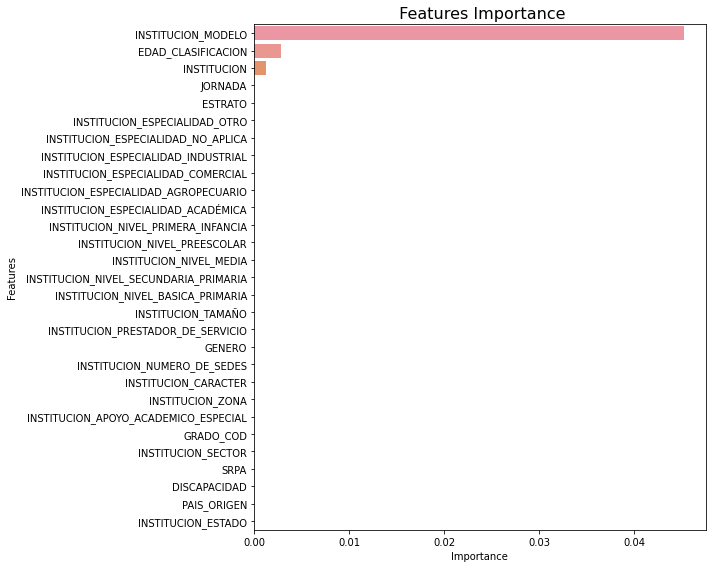

In [128]:
# Initializing figure    
fig = plt.subplots(figsize=(10, 8))

plot = sns.barplot(data=df_importance, y=df_importance["Feature"], x=df_importance["Importance"])

plt.title(" Features Importance", fontdict={ "fontsize": 16, "fontweight": "normal" })
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()